# Explainable AI

In [59]:
import os
import sys
sys.path.append('/Users/damienmellot/desktop/MLE/Projects/fml/stock-price-prediction/')

import warnings
warnings.filterwarnings('ignore')

import src.settings.base as stg
from src.infrastructure.datasetcreation import DataFrameBuilder
from src.domain.datatransformation import DatasetTransformer

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor

import eli5
from pdpbox import pdp, get_dataset, info_plots
from pycebox.ice import ice, ice_plot
import treeinterpreter
import shap

In [2]:
dfb = DataFrameBuilder(stg.MSFT_R21_data)
df = dfb.data
X = dfb.features
Y = dfb.target

In [3]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [10]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(5,5))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## 1. Scikit-learn feature_importances_ XAI

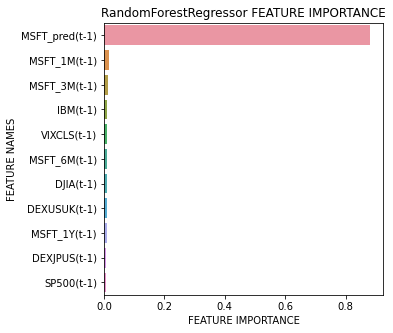

In [53]:
rfr = RandomForestRegressor(n_estimators=350)
rfr = rfr.fit(X_train,Y_train)
plot_feature_importance(rf[1].feature_importances_,names=stg.COLS, model_type='RandomForestRegressor ')

## 2. eli5 XAI

In [54]:
rfr.fit(X_train,Y_train)
eli5.show_weights(rfr)

## 3. PDP XAI

In [55]:
f_predict = lambda x: rfr.predict(x)

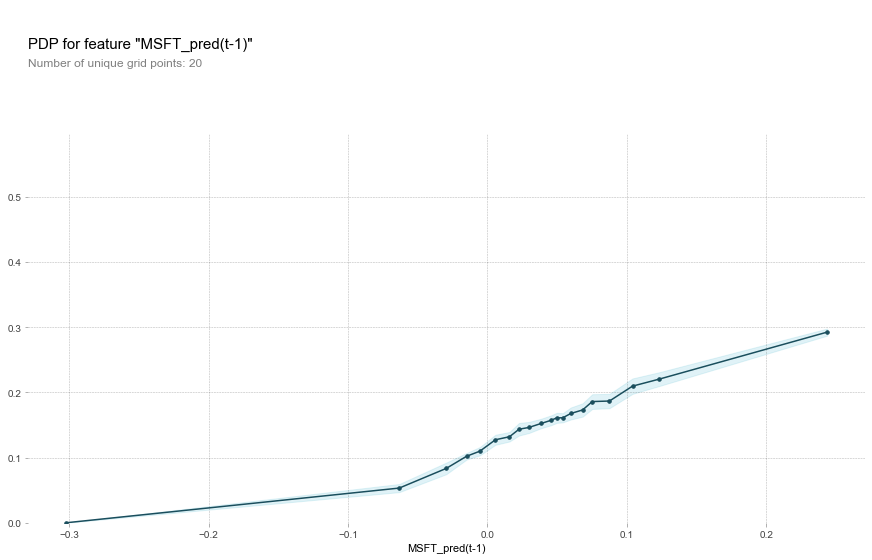

In [57]:
variable = stg.MSFT_lagged

pdp_goals = pdp.pdp_isolate(model=rfr,
                            dataset=X_test,
                            model_features=X_test.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', #possible values: 'equal' or 'percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True) # center arg center plots and compare each value to the first one
plt.show()

## 4. Pycebox XAI

Text(0.5, 1.0, 'ICE Curves')

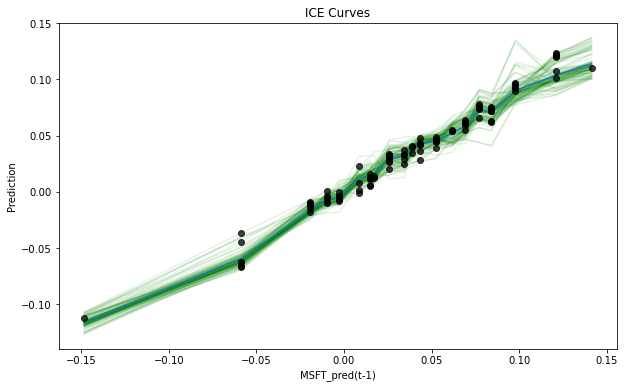

In [58]:
X_ref = X_test.copy().sample(100)
variable = stg.MSFT_lagged 

ice_df = ice(X_ref, variable, f_predict, num_grid_points=20)

fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
         alpha=0.1, plot_pdp=True, ax=ax_ice)

ax_ice.set_xlabel(variable)
ax_ice.set_ylabel('Prediction') 
ax_ice.set_title('ICE Curves')

## 5. Shap XAI

In [60]:
shap.initjs()
X_train_small = X_train.copy().sample(200)

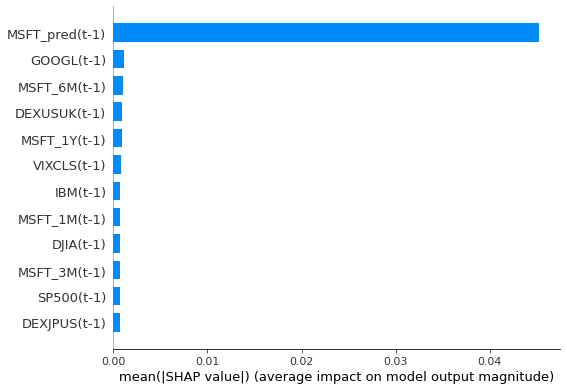

In [61]:
shap_values = shap.TreeExplainer(rfr).shap_values(X_train_small)
shap.summary_plot(shap_values, X_train_small, plot_type="bar")

In [86]:
X_ref_shap = X_test.copy()

In [93]:
%%time
explanation = shap.TreeExplainer(rfr)
shap_values = explanation.shap_values(X_ref_shap)
df_contrib = pd.DataFrame(shap_values, columns=X_ref_shap.columns, index=X_ref_shap.index)
bias = explanation.expected_value

CPU times: user 51.1 s, sys: 70.7 ms, total: 51.1 s
Wall time: 51.1 s


In [98]:
index = 2
shap.force_plot(explanation.expected_value, shap_values[index, :], X_ref_shap.iloc[index, :])

In [99]:
shap.force_plot(explanation.expected_value, shap_values, X_ref_shap)

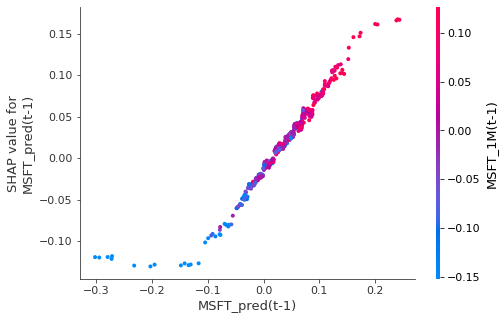

In [100]:
shap.dependence_plot(stg.MSFT_lagged, shap_values, X_ref_shap)

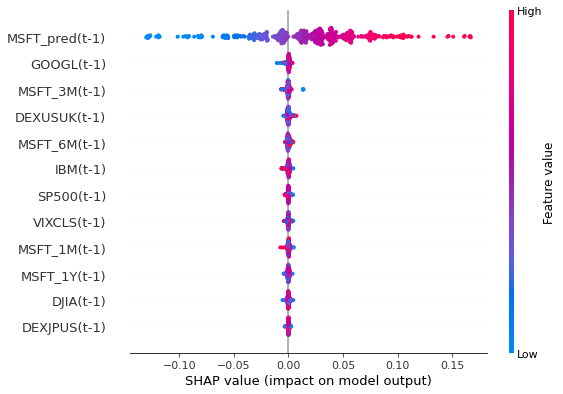

In [101]:
shap.summary_plot(shap_values, X_ref_shap, plot_type="dot")